## Project 1
- Mike Ames 
- amesam@wfu.edu
- 17May2020


### Load Packages
-------



In [1]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
import warnings
warnings.filterwarnings('ignore')
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -- sklearn modules 
from sklearn.model_selection import train_test_split   #- partition train/test split 
from sklearn.tree import DecisionTreeClassifier        #- create a decison tree 
from sklearn.tree import export_text                   #- export tree as text rules 
from sklearn import tree

# -- visualize decision trees and decision surfaces 
import graphviz 

# -- need this to render charts in notebook -- 
%matplotlib inline

## 1. Stage 
----- 
import our dataset into a pandas dataframe


In [2]:
df = pd.read_csv("./data/churn.csv", na_values="?")
#df = df.drop('Unnamed: 0', axis=1)
df.head()


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


## 2.  Clean up Column Names

*It's just not fun dealing with ill-formed columns*

- remove leading and trailing characters
- replace spaces with underscores _ 
- change case to lower case
- remove various special characters

In [3]:
df.columns = ( df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('-', '_')
    .str.replace('(', '')
    .str.replace(')', '')
    .str.replace('?', '')
    .str.replace('\'', '') # notice the backslash \ this is an escape character
)
df.columns

Index(['state', 'account_length', 'area_code', 'phone', 'intl_plan',
       'vmail_plan', 'vmail_message', 'day_mins', 'day_calls', 'day_charge',
       'eve_mins', 'eve_calls', 'eve_charge', 'night_mins', 'night_calls',
       'night_charge', 'intl_mins', 'intl_calls', 'intl_charge',
       'custserv_calls', 'churn'],
      dtype='object')

## 3. Describe data
### Check Target
-----
always start by understanding your target value 


In [4]:
df['churn'].value_counts(normalize=True)

False.    0.855086
True.     0.144914
Name: churn, dtype: float64

In [5]:
default_impurity = 2*0.855086*0.144914

print("Default impurity: {:2.4}".format(default_impurity))

Default impurity: 0.2478


## How Decision Trees Work

-----

Trees evaluate each varaible and identify likely splits based on gini or entropy 

we can do this manually by evaluating numeric and categorical data separately 


state
Best split point ginix: 0.1068
churn state    False.     True.     ginix
11       HI  0.943396  0.056604  0.106800
0        AK  0.942308  0.057692  0.108728
3        AZ  0.937500  0.062500  0.117188
45       VA  0.935065  0.064935  0.121437
12       IA  0.931818  0.068182  0.127066
18       LA  0.921569  0.078431  0.144560
29       NE  0.918033  0.081967  0.150497
14       IL  0.913793  0.086207  0.157551
48       WI  0.910256  0.089744  0.163379
39       RI  0.907692  0.092308  0.167574
7        DC  0.907407  0.092593  0.168038
42       TN  0.905660  0.094340  0.170879
49       WV  0.905660  0.094340  0.170879
32       NM  0.903226  0.096774  0.174818
28       ND  0.903226  0.096774  0.174818
1        AL  0.900000  0.100000  0.180000
46       VT  0.890411  0.109589  0.195159
24       MO  0.888889  0.111111  0.197531
50       WY  0.883117  0.116883  0.206443
13       ID  0.876712  0.123288  0.216176
15       IN  0.873239  0.126761  0.221385
9        FL  0.873016  0.126984  0.2217

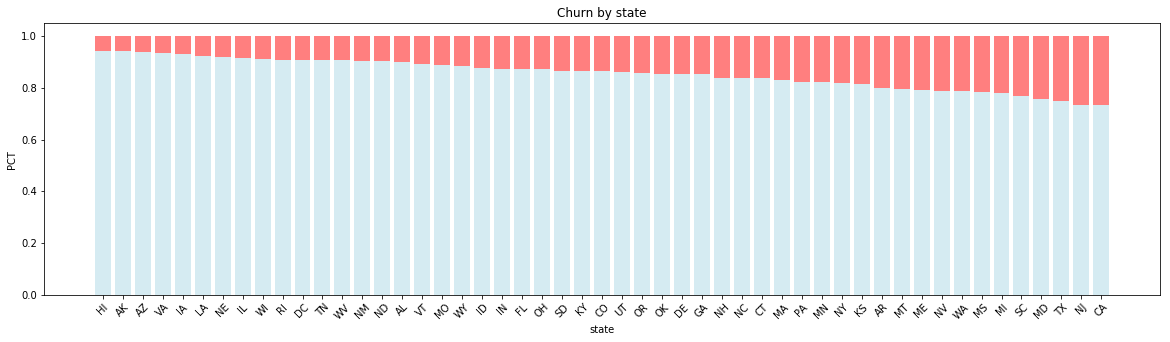

intl_plan
Best split point ginix: 0.2035
churn intl_plan    False.     True.     ginix
0            no  0.885050  0.114950  0.203473
1           yes  0.575851  0.424149  0.488493


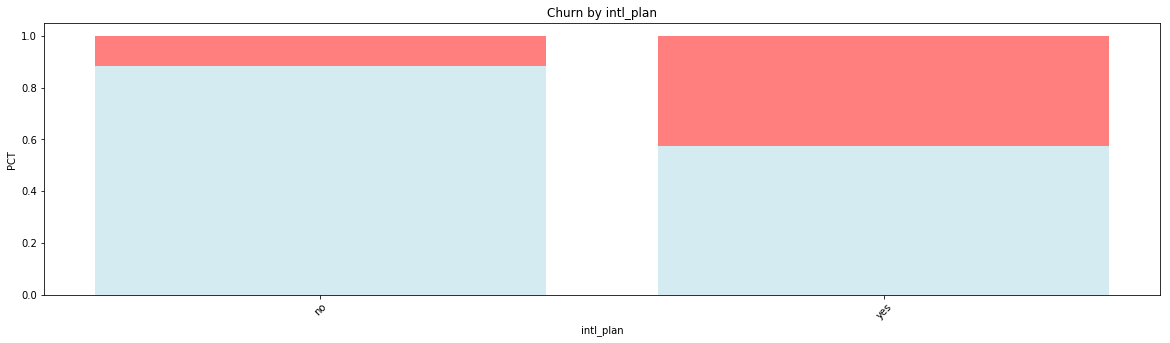

vmail_plan
Best split point ginix: 0.1585
churn vmail_plan    False.     True.     ginix
1            yes  0.913232  0.086768  0.158478
0             no  0.832849  0.167151  0.278423


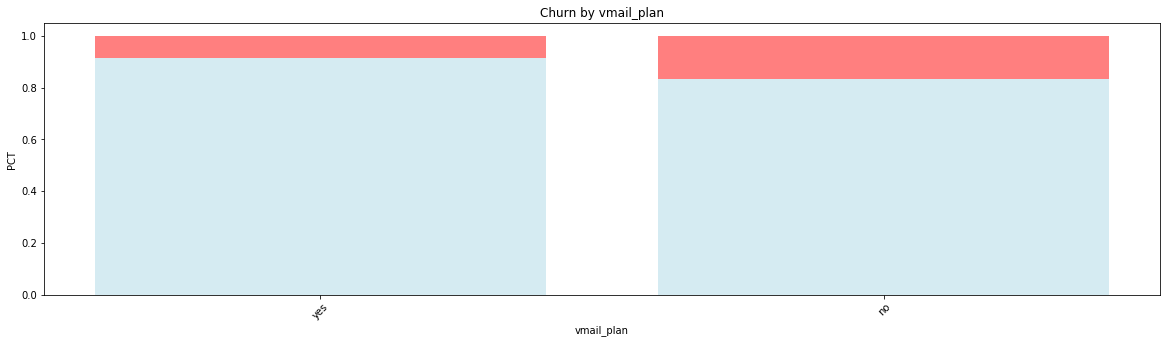

churn
Best split point ginix: 0.0
churn   churn  False.  True.  ginix
0      False.     1.0    0.0    0.0
1       True.     0.0    1.0    0.0


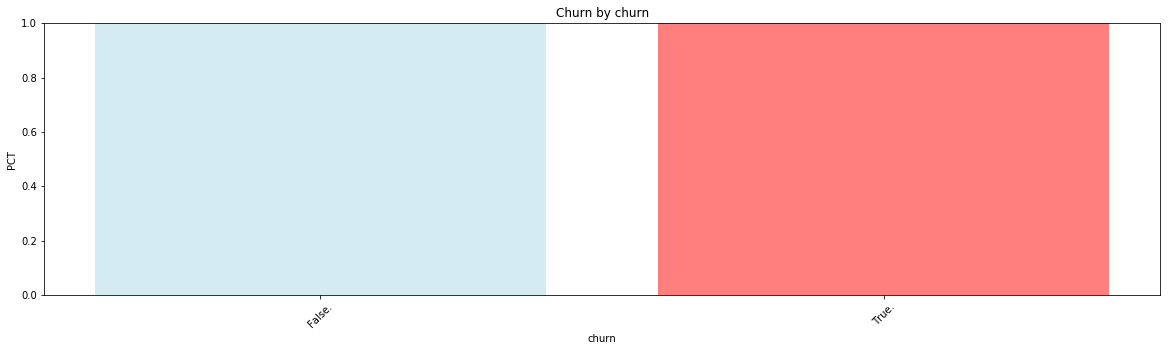

split_1
Best split point ginix: 0.2025
churn split_1    False.     True.     ginix
0        left  0.885687  0.114313  0.202491
1       right  0.400000  0.600000  0.480000


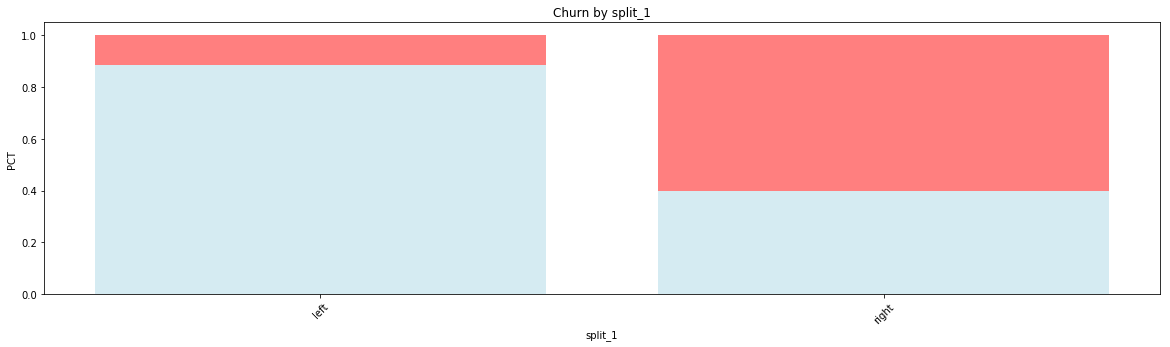

In [20]:
def bar_chars(df, col):
    df = df.copy()
    # -- normalize index converts to row percetages, sort ascending=False means it will sort largest to smallest 
    ctab = pd.crosstab(df[col], df["churn"], normalize="index").reset_index().sort_values('False.',ascending=False )
   
    ctab["ginix"] = 2*ctab["False."]*ctab["True."]
    
    print("Best split point ginix: {:2.4}".format(ctab["ginix"].min()))
    print(ctab)
  
    plt.figure(figsize=(20,5))
    # -- check out bottom 
    plt.bar(ctab[col], ctab['False.'], facecolor='lightblue', alpha=0.5)
    plt.bar(ctab[col], ctab['True.'], bottom=ctab['False.'], facecolor='red', alpha=0.5)
    plt.title('Churn by ' + col)
    plt.ylabel('PCT')
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.show()

for col in df.select_dtypes(include=['object']).columns:
    if col != 'phone':
        print(col)
        bar_chars(df,col)

account_length
Best split point ginix: 0.2026
churn             bin    False.     True.     ginix
5      (139.0, 157.0]  0.885609  0.114391  0.202612


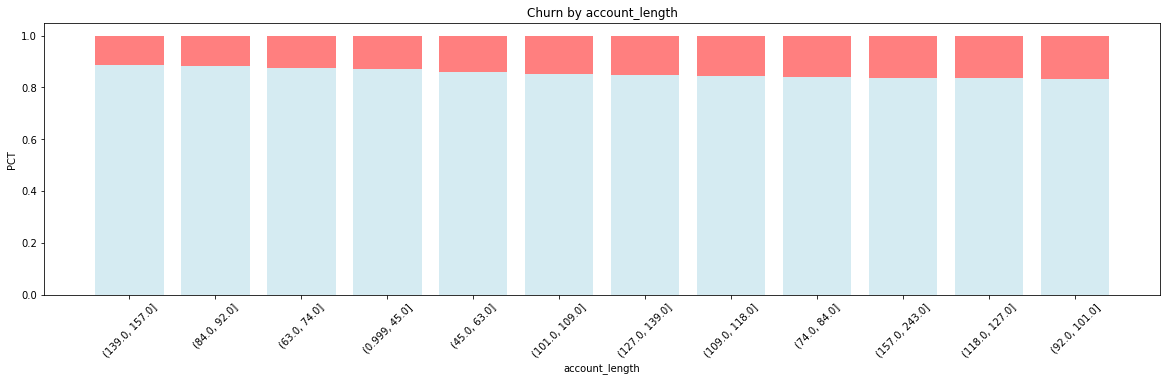

area_code
Best split point ginix: 0.246
churn               bin    False.     True.     ginix
0      (407.999, 415.0]  0.856398  0.143602  0.245961


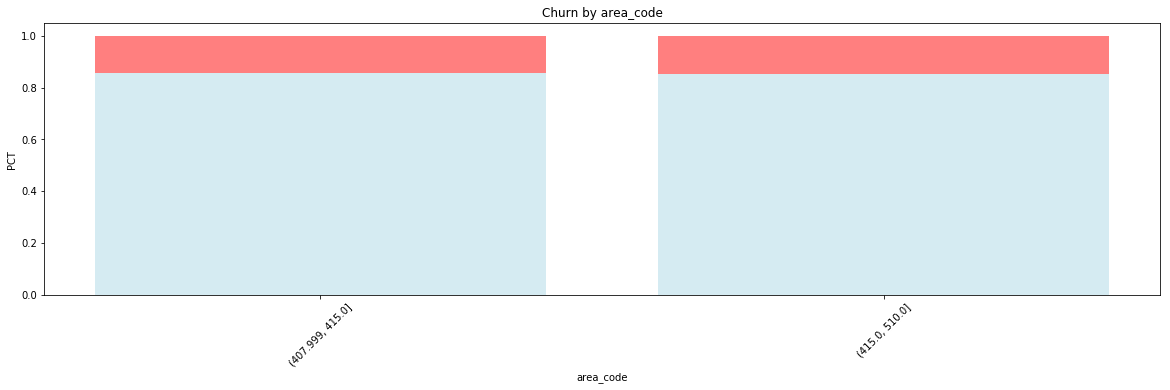

vmail_message
Best split point ginix: 0.1768
churn           bin    False.     True.     ginix
1      (29.0, 51.0]  0.902004  0.097996  0.176785


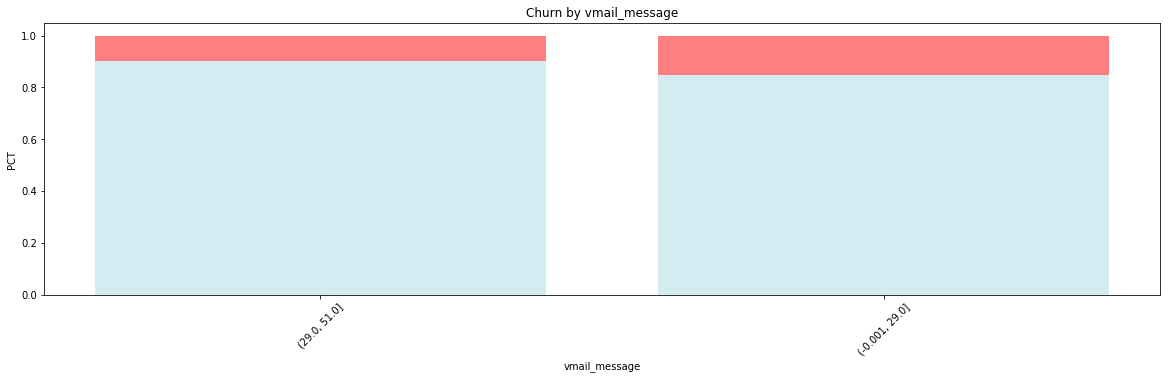

day_mins
Best split point ginix: 0.05629
churn             bin    False.     True.     ginix
15     (203.8, 209.9]  0.971014  0.028986  0.056291


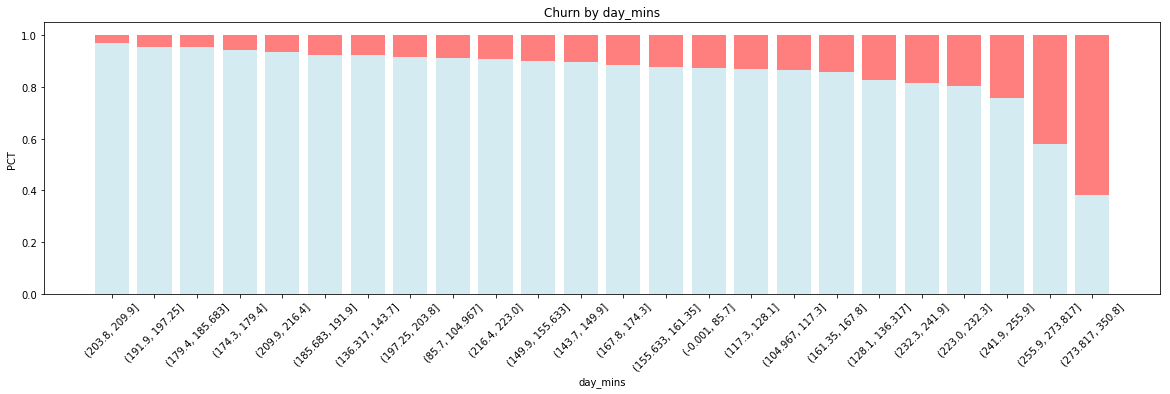

day_calls
Best split point ginix: 0.2176
churn            bin    False.     True.     ginix
9      (96.0, 101.0]  0.875776  0.124224  0.217584


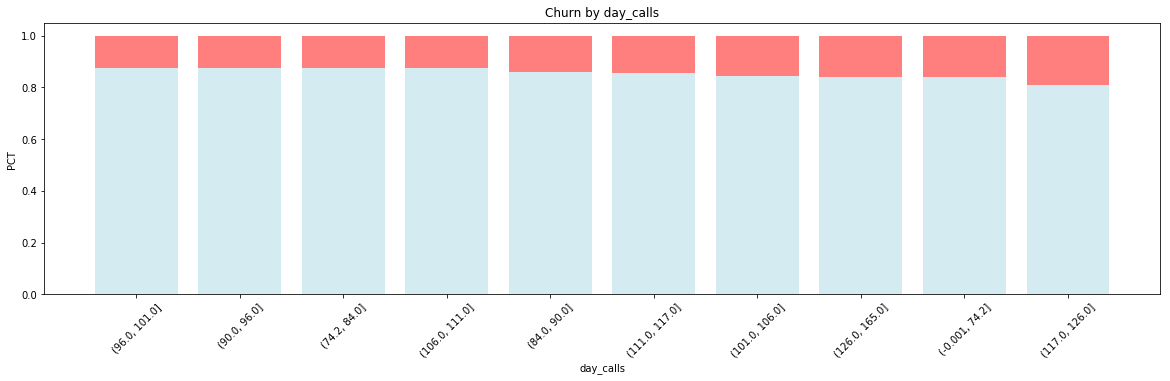

day_charge
Best split point ginix: 0.05629
churn             bin    False.     True.     ginix
16     (34.65, 35.68]  0.971014  0.028986  0.056291


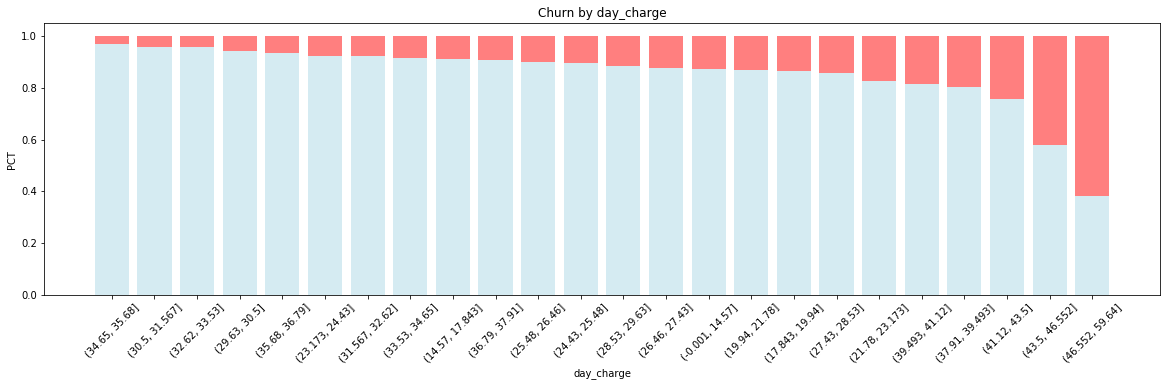

eve_mins
Best split point ginix: 0.1049
churn             bin    False.     True.     ginix
3      (144.3, 154.0]  0.944444  0.055556  0.104938


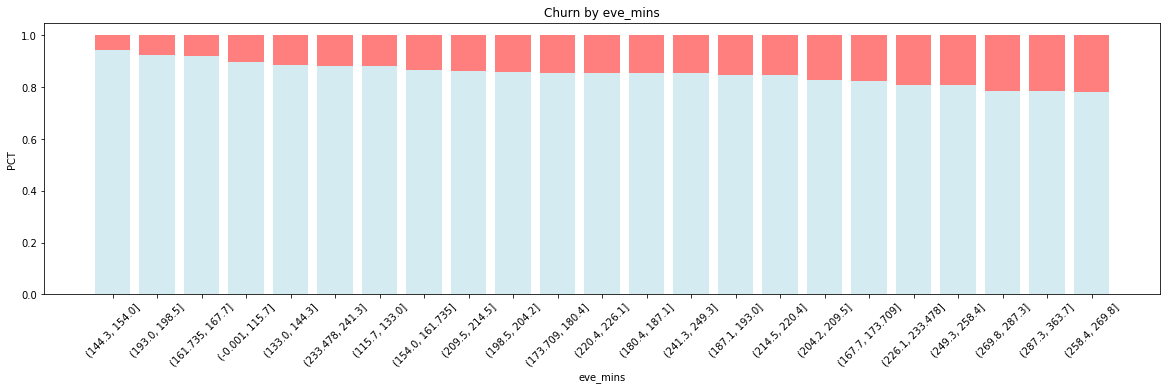

eve_calls
Best split point ginix: 0.2166
churn           bin    False.     True.     ginix
6      (75.0, 84.0]  0.876404  0.123596  0.216639


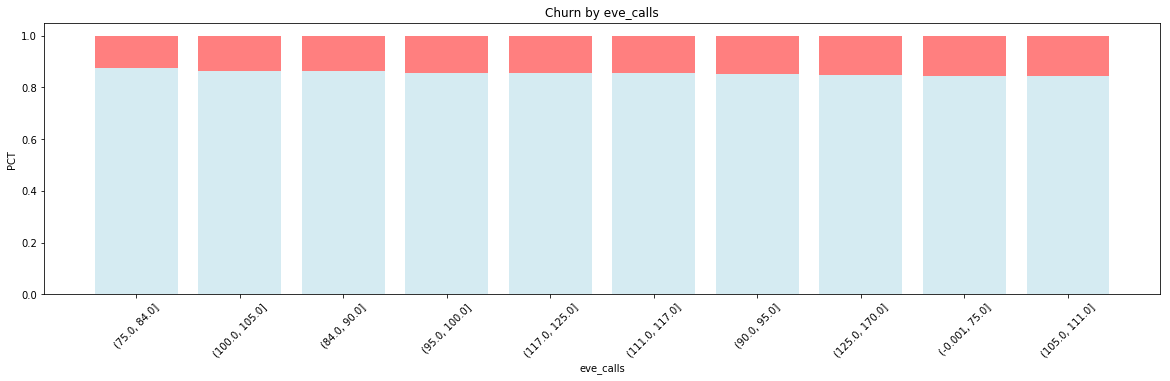

eve_charge
Best split point ginix: 0.1056
churn             bin    False.     True.     ginix
2      (12.27, 13.09]  0.944056  0.055944  0.105629


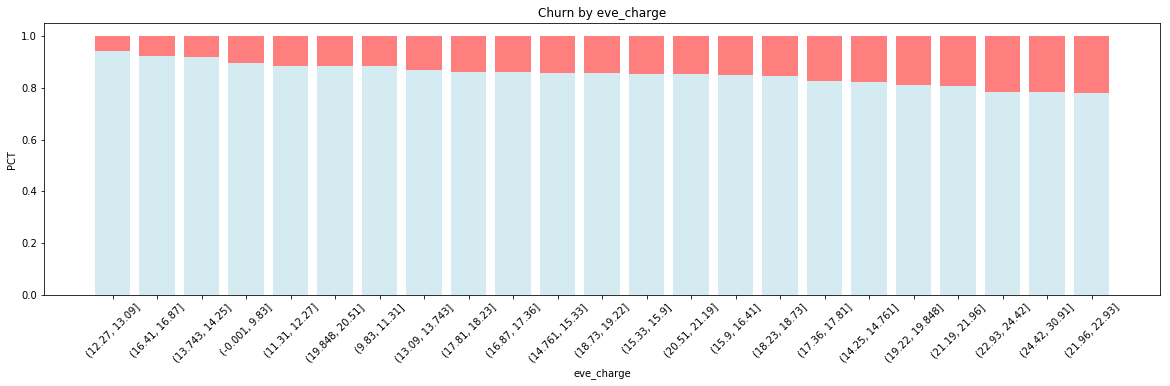

night_mins
Best split point ginix: 0.1164
churn                            bin    False.     True.     ginix
16     (23.198999999999998, 114.474]  0.937931  0.062069  0.116433


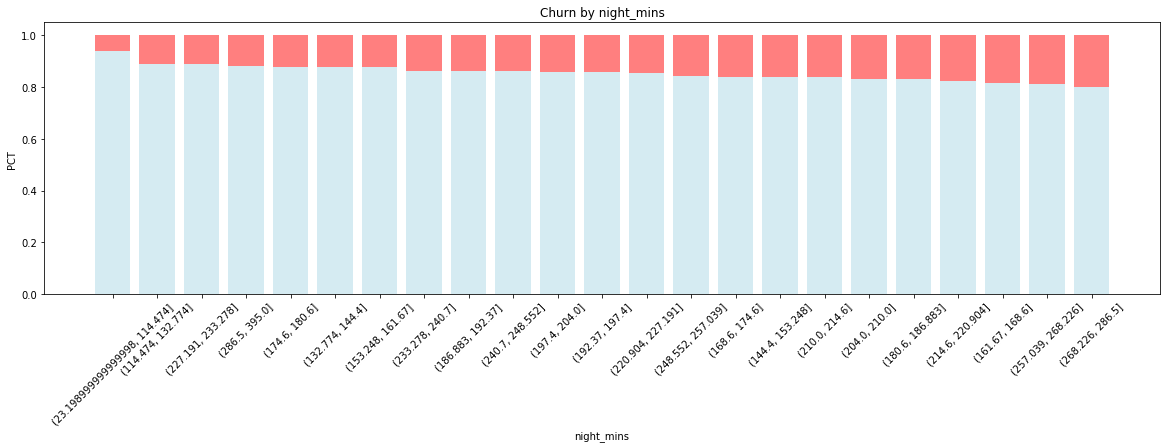

night_calls
Best split point ginix: 0.2095
churn           bin    False.     True.     ginix
8      (90.0, 95.0]  0.881098  0.118902  0.209529


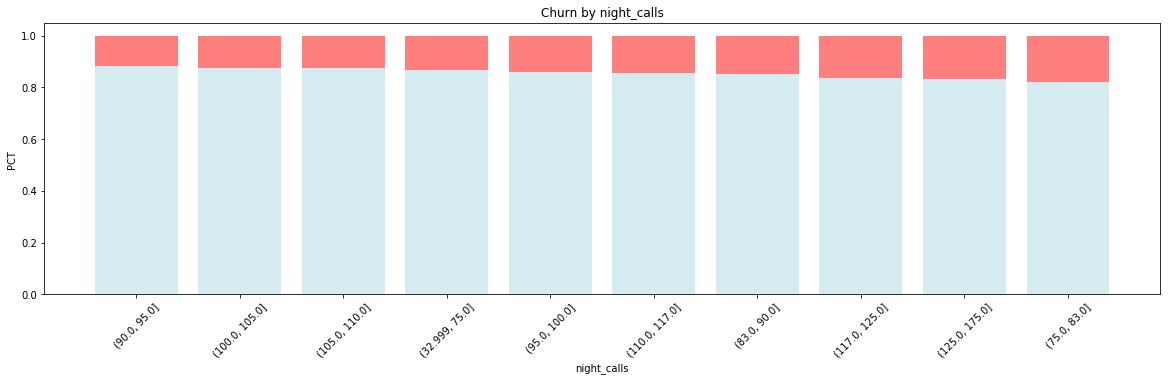

night_charge
Best split point ginix: 0.1231
churn                          bin    False.     True.     ginix
0      (1.0390000000000001, 5.316]  0.934132  0.065868  0.123059


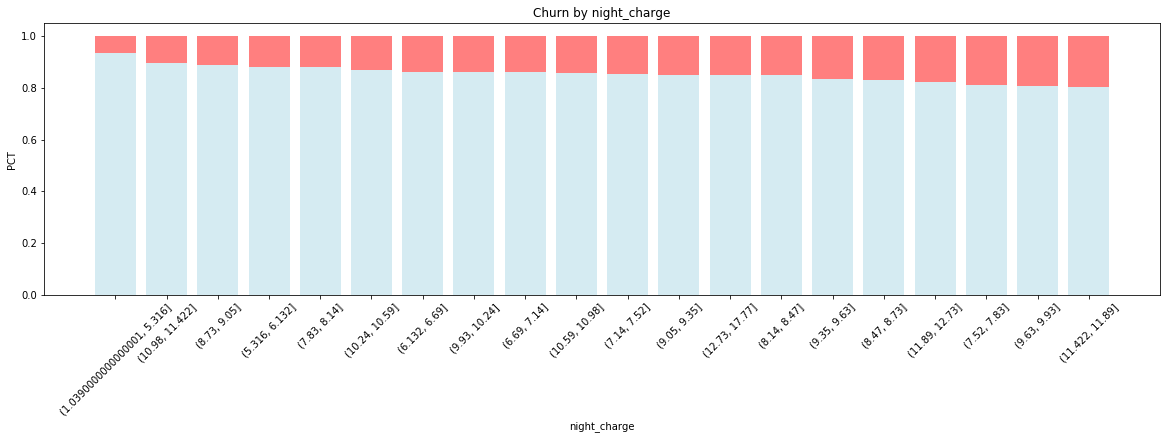

intl_mins
Best split point ginix: 0.1616
churn         bin    False.     True.    ginix
7      (6.5, 7.8]  0.911315  0.088685  0.16164


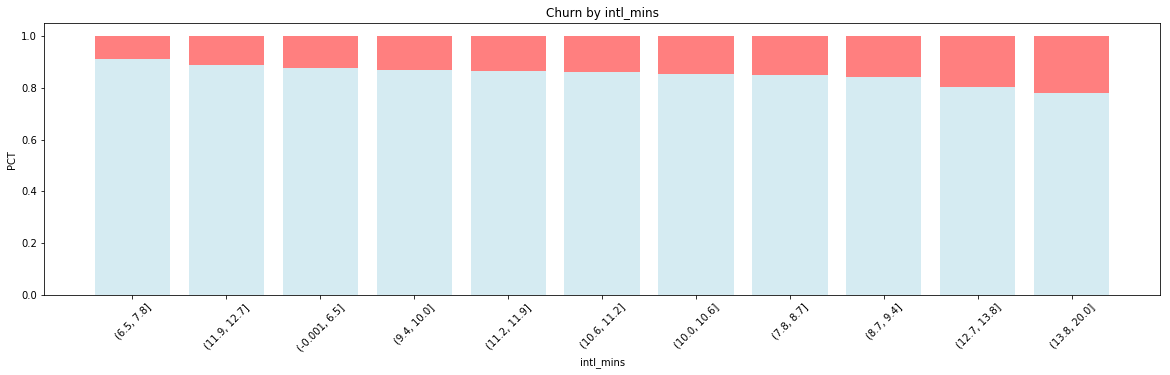

intl_calls
Best split point ginix: 0.1994
churn         bin    False.     True.     ginix
3      (4.0, 5.0]  0.887712  0.112288  0.199359


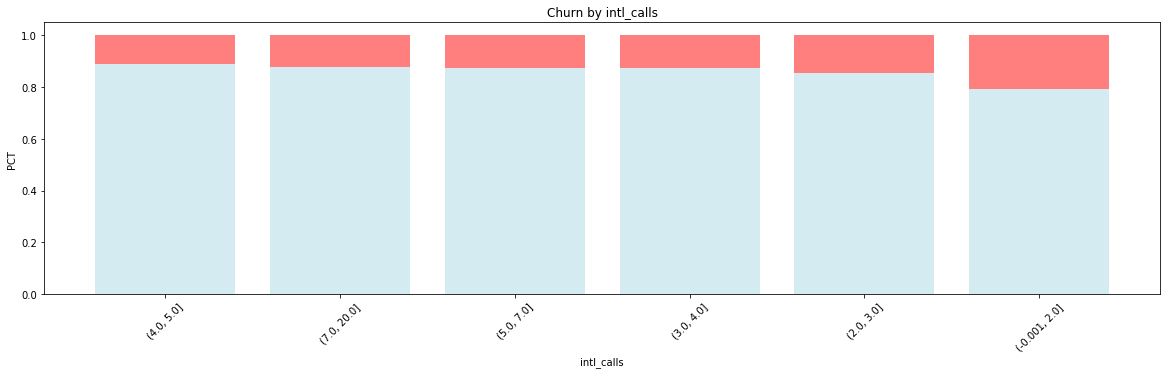

intl_charge
Best split point ginix: 0.1616
churn           bin    False.     True.    ginix
1      (1.76, 2.11]  0.911315  0.088685  0.16164


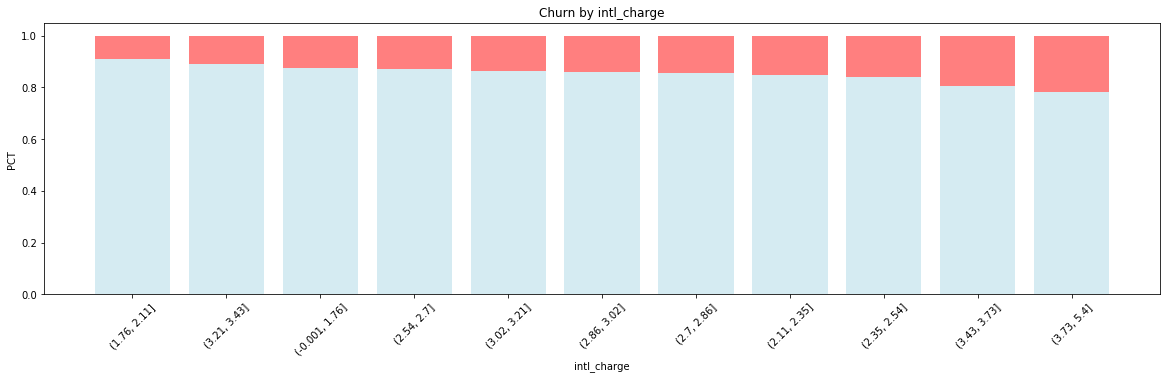

custserv_calls
Best split point ginix: 0.2019
churn            bin    False.     True.     ginix
0      (-0.001, 1.0]  0.886049  0.113951  0.201932


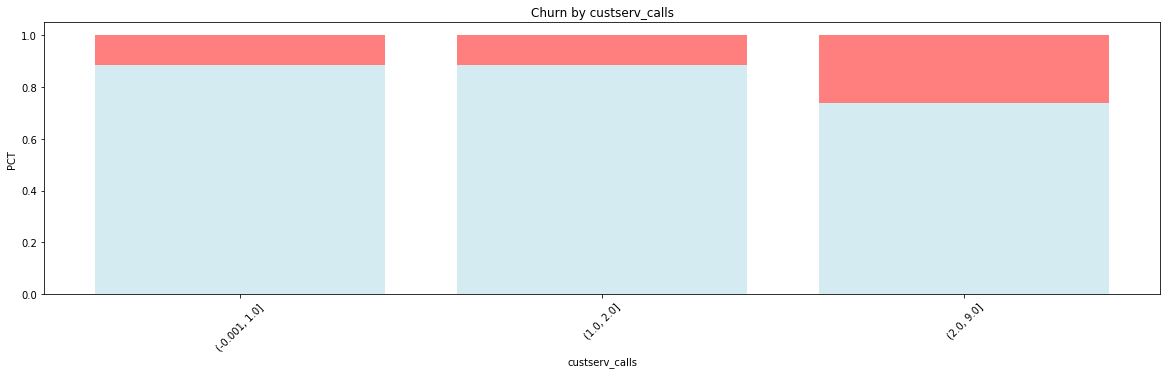

In [21]:
## -- take a look at Numeric Columns 
def eval_numeric(df, col):
    df = df.copy()
    n = df[col].nunique()
    
    # -- rice rule -- 
    k = int(round(2*(n**(1/3)),0)) 
    
    df['bin'] = pd.qcut(df[col], q=k, duplicates='drop')
    df['bin'] = df['bin'].astype(str)
    
    ctab = pd.crosstab(df["bin"], df["churn"], normalize="index").reset_index().sort_values('False.',ascending=False )
   
    ctab["ginix"] = 2*ctab["False."]*ctab["True."]
    
    print("Best split point ginix: {:2.4}".format(ctab["ginix"].min()))
    
    print(ctab[ctab["ginix"]== ctab["ginix"].min()])
    
    
    plt.figure(figsize=(20,5))
  
    # -- check out bottom 
    plt.bar(ctab["bin"], ctab['False.'], facecolor='lightblue', alpha=0.5)
    plt.bar(ctab["bin"], ctab['True.'], bottom=ctab['False.'], facecolor='red', alpha=0.5)
    plt.title('Churn by ' + col)
    plt.ylabel('PCT')
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.show()
    
    

for col in df.select_dtypes(include=['float64', 'int64']):
    print(col)
    eval_numeric(df, col)

In [22]:

numeric_features = ['account_length', 'area_code', 'vmail_message', 'day_mins', 'day_calls',
       'day_charge', 'eve_mins', 'eve_calls', 'eve_charge', 'night_mins',
       'night_calls', 'night_charge', 'intl_mins', 'intl_calls', 'intl_charge',
       'custserv_calls']

numeric_features

['account_length',
 'area_code',
 'vmail_message',
 'day_mins',
 'day_calls',
 'day_charge',
 'eve_mins',
 'eve_calls',
 'eve_charge',
 'night_mins',
 'night_calls',
 'night_charge',
 'intl_mins',
 'intl_calls',
 'intl_charge',
 'custserv_calls']

In [9]:

categorical_features = ['state', 'intl_plan', 'vmail_plan']

categorical_features

['state', 'intl_plan', 'vmail_plan']

In [10]:
df_prep = df.copy()
# 2. deal with nulls using fillna 
df_prep[numeric_features]     = df_prep[numeric_features].fillna(-1)
df_prep[categorical_features] = df_prep[categorical_features].astype('str').fillna('missing')
df_prep.isnull().sum(axis = 0)

state             0
account_length    0
area_code         0
phone             0
intl_plan         0
vmail_plan        0
vmail_message     0
day_mins          0
day_calls         0
day_charge        0
eve_mins          0
eve_calls         0
eve_charge        0
night_mins        0
night_calls       0
night_charge      0
intl_mins         0
intl_calls        0
intl_charge       0
custserv_calls    0
churn             0
dtype: int64

In [11]:
target = "churn"
y = df[target].values
df_prep = pd.get_dummies(df[numeric_features+categorical_features], columns=categorical_features)
df_prep.columns

Index(['account_length', 'area_code', 'vmail_message', 'day_mins', 'day_calls',
       'day_charge', 'eve_mins', 'eve_calls', 'eve_charge', 'night_mins',
       'night_calls', 'night_charge', 'intl_mins', 'intl_calls', 'intl_charge',
       'custserv_calls', 'state_AK', 'state_AL', 'state_AR', 'state_AZ',
       'state_CA', 'state_CO', 'state_CT', 'state_DC', 'state_DE', 'state_FL',
       'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN',
       'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME',
       'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC',
       'state_ND', 'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV',
       'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI',
       'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA',
       'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY',
       'intl_plan_no', 'intl_plan_yes', 'vmail_plan_no', 'vmail_plan_yes'

In [12]:
df_prep.head()

,account_length,area_code,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,intl_plan_no,intl_plan_yes,vmail_plan_no,vmail_plan_yes
0,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,...,0,0,0,0,0,0,1,0,0,1
1,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,...,0,0,0,0,0,0,1,0,0,1
2,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,...,0,0,0,0,0,0,1,0,1,0
3,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,...,0,0,0,0,0,0,0,1,1,0
4,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,...,0,0,0,0,0,0,0,1,1,0


In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_prep,y, test_size=0.30)
print("train pct: {:2.2%}".format(X_train.shape[0]/df.shape[0]))
print("test  pct: {:2.2%}".format(X_test.shape[0]/df.shape[0]))

train pct: 70.00%
test  pct: 30.00%


In [14]:
dtree = tree.DecisionTreeClassifier(
                                    criterion='gini',
                                    max_depth=5,
                                    min_samples_leaf=2)

dtree = dtree.fit(X_train, y_train)
dtree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

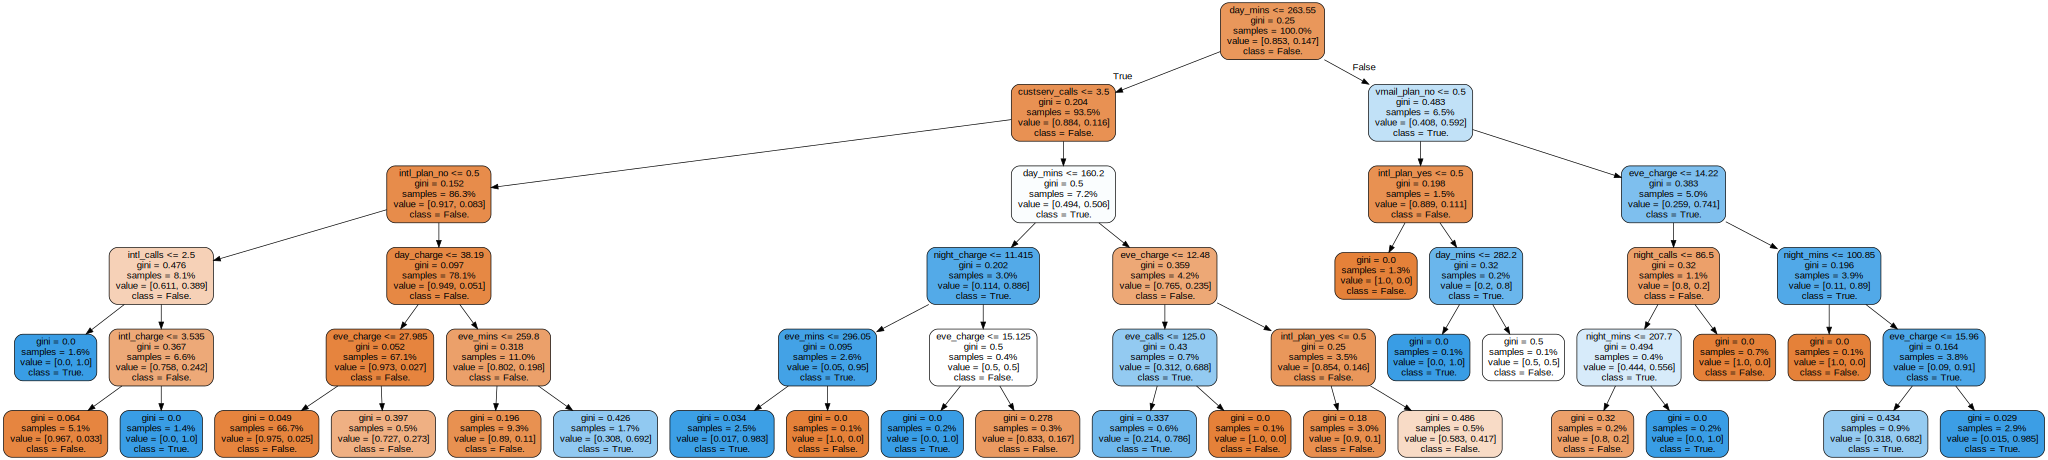

In [15]:
dot_data = tree.export_graphviz(dtree, 
                                out_file=None, 
                                feature_names=X_train.columns, 
                                class_names = ["False.", "True."],
                                filled=True, 
                                impurity=True,
                                proportion=True,
                                rounded=True,  
                                  special_characters=False)  
graph = graphviz.Source(dot_data)  
graph

In [16]:
default_impurity = 2*0.855086*0.144914

print("Default impurity: {:2.4}".format(default_impurity))

Default impurity: 0.2478


In [17]:
# -- default the predicted target 
df.loc[:, "split_1"] = 'right'

# -- update where rules are met 
df.loc[df['day_mins'] <= 264.5, 'split_1' ] = 'left'
pd.crosstab(df.split_1, df.churn)

churn,False.,True.
split_1,,
left,2766,357
right,84,126


In [18]:
# - probablities 
ctab = pd.crosstab(df.split_1, df.churn, normalize="index").reset_index()
ctab

churn,split_1,False.,True.
0,left,0.885687,0.114313
1,right,0.400000,0.600000


In [19]:
# - simple gini 
ctab["ginix"] = 2*ctab["False."]*ctab["True."]

ctab.loc[ctab["split_1"]=="right"]

churn,split_1,False.,True.,ginix
1,right,0.4,0.6,0.48
